In [11]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import time
import datetime
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(20, 15)})
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# Colors and Template
colors=px.colors.qualitative.Plotly
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))

import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from yahooquery import Ticker

In [12]:
def stock_data(stock_name, duration, company_name):#duration in years

    end_time = datetime.now()
    start_time = datetime(datetime.now().year - duration, datetime.now().month, datetime.now().day)  #using data of exactly duration year before
    stock=yf.download(stock_name,start_time,end_time)
    stock["comany_name"]=company_name
    return stock

apple_stocks=stock_data('AAPL', 10,'Apple')


[*********************100%%**********************]  1 of 1 completed


In [15]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

In [13]:
import xgboost as xgb
from sklearn import metrics

def feature_engineering(df, n=14):
  close = df['Close']
  delta = close.diff()
  delta = delta[1:]
  pricesUp = delta.copy()
  pricesDown = delta.copy()
  pricesUp[pricesUp < 0] = 0
  pricesDown[pricesDown > 0] = 0
  rollUp = pricesUp.rolling(n).mean()
  rollDown = pricesDown.abs().rolling(n).mean()
  rs = rollUp / rollDown
  rsi = 100.0 - (100.0 / (1.0 + rs))
  df['RSI'] = rsi.fillna(0)
  df['SMA_5'] = df['Close'].rolling(5).mean().shift()

def preprocess_data(df):
  l = len(df)
  split = 0.8
  train = df[:int(split*l)]
  test = df[int(split*l):]
  fig , ax = plt.subplots(figsize=(15,9))
  train['Close'].plot(ax= ax , label = 'Training Set' , title='Data Train/Test Split' , linewidth = 1, markersize = 5)
  test['Close'].plot(ax= ax , label = 'Test Set' , linewidth = 1, markersize = 5)
  train.drop('comany_name', axis=1, inplace=True)
  test.drop('comany_name', axis=1, inplace=True)
  # ax.axvline(pd.Timestamp(split_date),color='black',ls='--')
  ax.legend(['Training Set','Test Set'])
  plt.show()

def XBGoostRegression(train , test):
  train_features = ['Open','High','Low','Adj Close','Volume','SMA_5']
  predictor_variables = ['Close']

  x_train = train[train_features]
  y_train = train[predictor_variables]

  x_test = test[train_features]
  y_test = test[predictor_variables]

  XGB = xgb.XGBRegressor(base_score = 0.5,
                        booster = 'gbtree',
                        n_estimators = 3000,
                        early_stopping_rounds=50,
                        max_depth=6,
                        learning_rate=0.01,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        gamma=0,
                        reg_alpha=0,
                        reg_lambda=1)
  XGB.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)
  return XGB

def evaluate_xgboost(XGB,test,train,df):
  F_Score_Plot = pd.DataFrame(data = XGB.feature_importances_,index = XGB.feature_names_in_,columns=['importance'])
  F_Score_Plot.sort_values('importance').plot(kind='barh',title='Feature Importance')
  plt.show()

  predictions = XGB.predict(x_test)
  test['predictions'] = predictions
  df = df.merge(test[['predictions']],how='left',left_index=True,right_index=True)
  df.tail(2)
  ax = df[['Close']].plot(figsize=(15,5))

  df['predictions'].plot(ax=ax,style='.')

  plt.legend(["Actual Prices","XGBoost Predictions"])
  ax.set_title('Actual Past Data vs Predictions')
  plt.show()


  score = np.sqrt(metrics.mean_squared_error(test['Close'],test['predictions']))

  print("The Mean Squared Error using XGBoost model was : ",score)


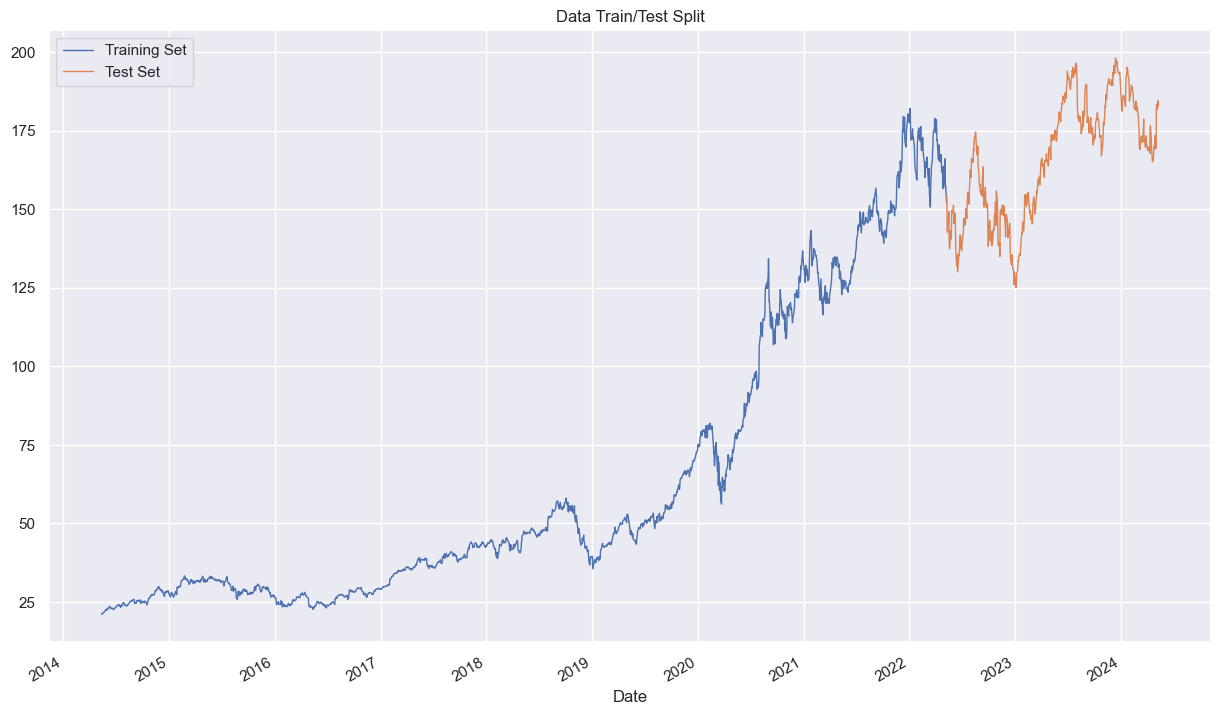

[0]	validation_0-rmse:76.29330	validation_1-rmse:164.78148
[100]	validation_0-rmse:28.27853	validation_1-rmse:65.66450
[200]	validation_0-rmse:10.50608	validation_1-rmse:27.92116
[300]	validation_0-rmse:3.92709	validation_1-rmse:13.73433
[400]	validation_0-rmse:1.50178	validation_1-rmse:8.40880
[500]	validation_0-rmse:0.63300	validation_1-rmse:6.40462
[600]	validation_0-rmse:0.35284	validation_1-rmse:5.65502
[700]	validation_0-rmse:0.27156	validation_1-rmse:5.41020
[800]	validation_0-rmse:0.24286	validation_1-rmse:5.31167
[900]	validation_0-rmse:0.22788	validation_1-rmse:5.26726
[1000]	validation_0-rmse:0.21731	validation_1-rmse:5.24515
[1100]	validation_0-rmse:0.20749	validation_1-rmse:5.23349
[1200]	validation_0-rmse:0.19818	validation_1-rmse:5.23024
[1266]	validation_0-rmse:0.19222	validation_1-rmse:5.23258


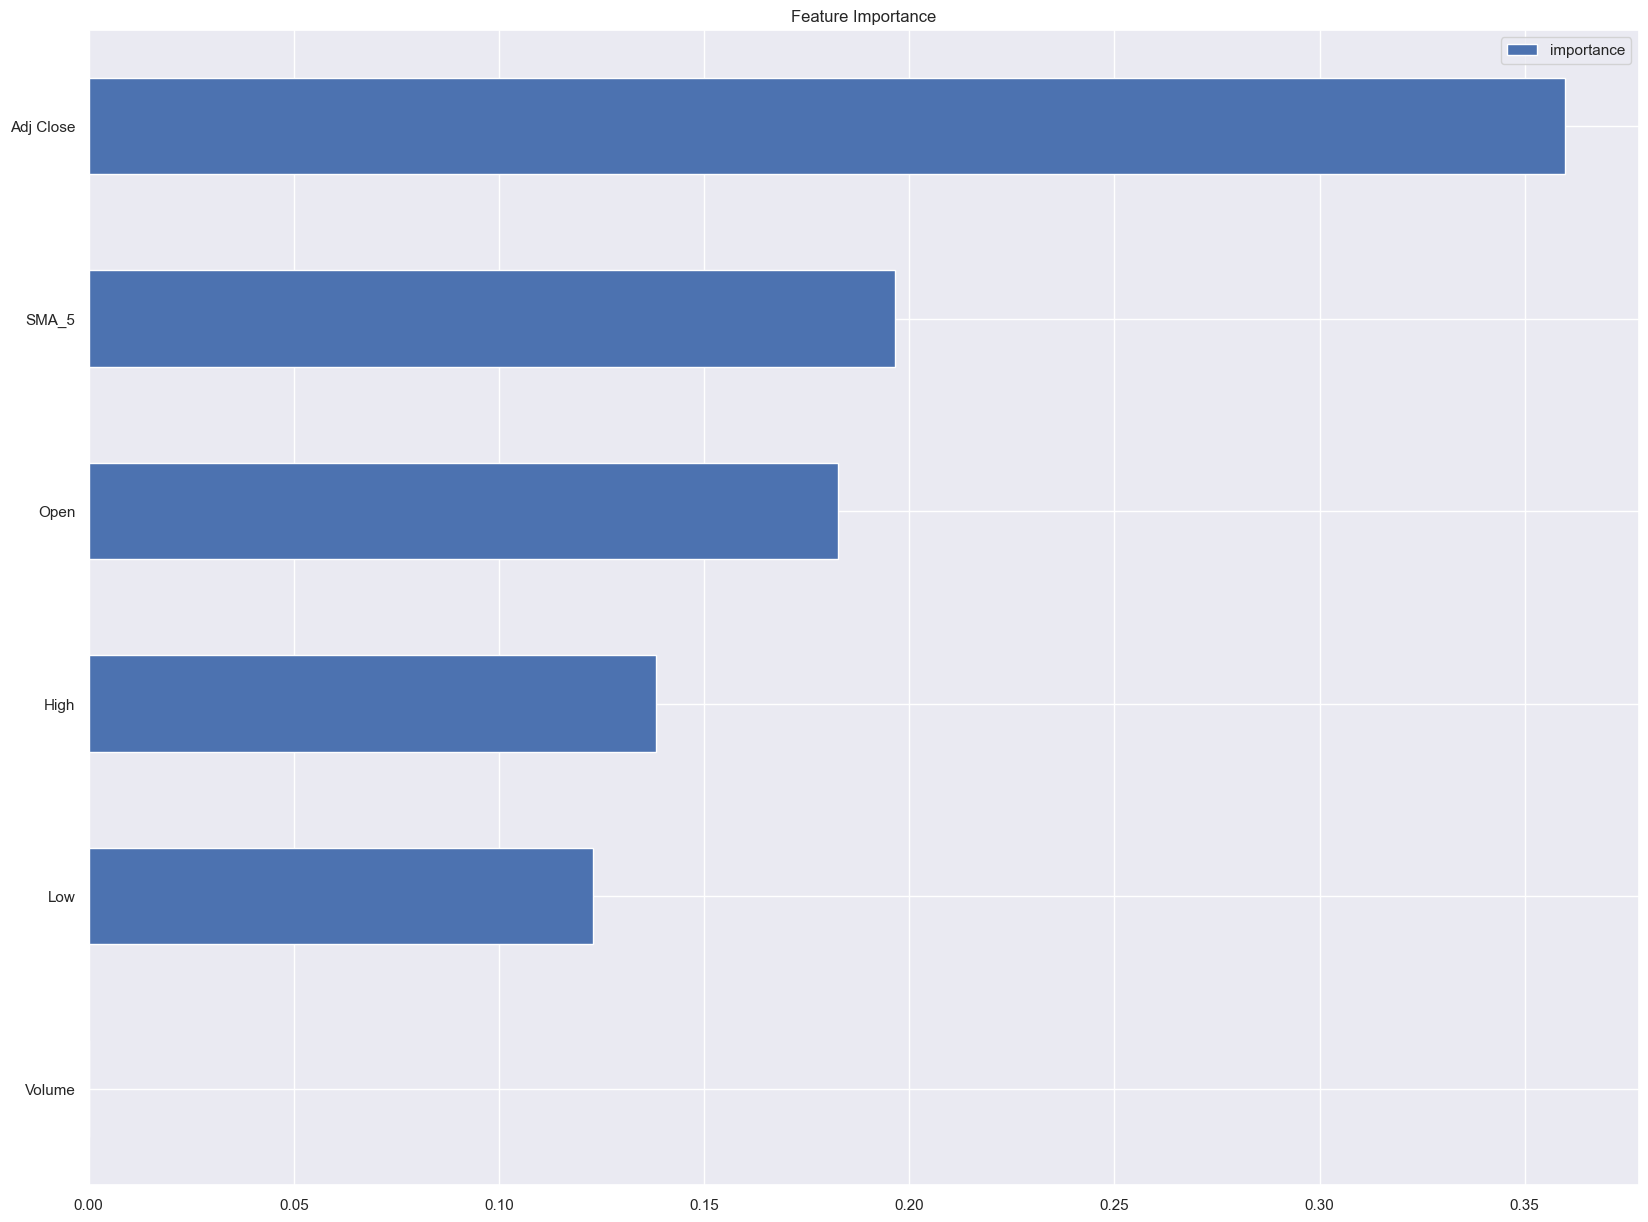

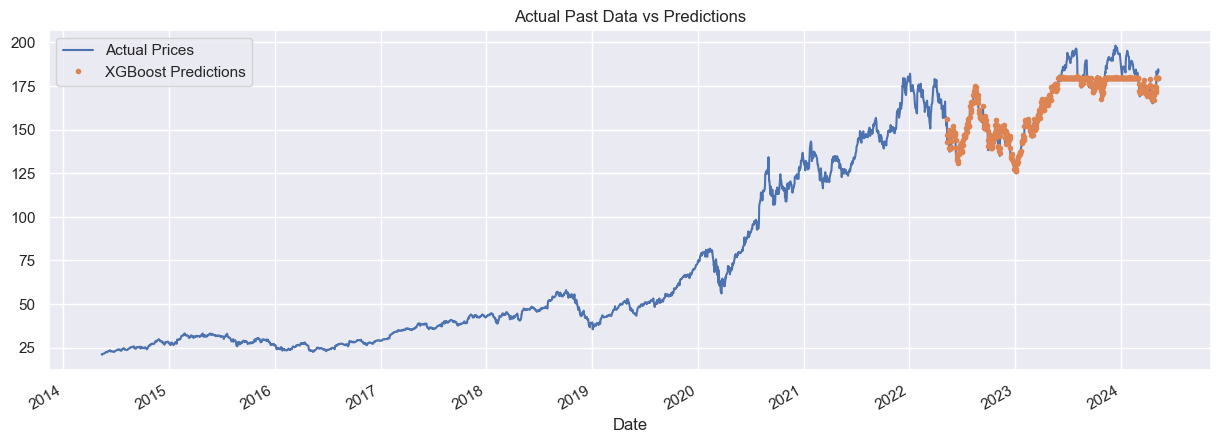

The Mean Squared Error using XGBoost model was :  5.229258161526865


,Metric,Value
0,MAPE,1.63
1,MAE,2.98
2,MSE,27.35
3,RMSE,5.23
4,R2,0.92
5,SMAPE,1.67


In [16]:
#starting the xgboost algrorithm

def feature_engineering(df, n=14):
  close = df['Close']
  delta = close.diff()
  delta = delta[1:]
  pricesUp = delta.copy()
  pricesDown = delta.copy()
  pricesUp[pricesUp < 0] = 0
  pricesDown[pricesDown > 0] = 0
  rollUp = pricesUp.rolling(n).mean()
  rollDown = pricesDown.abs().rolling(n).mean()
  rs = rollUp / rollDown
  rsi = 100.0 - (100.0 / (1.0 + rs))
  df['RSI'] = rsi.fillna(0)
  df['SMA_5'] = df['Close'].rolling(5).mean().shift()

def preprocess_data(df):
  l = len(df)
  split = 0.8
  train = df[:int(split*l)]
  test = df[int(split*l):]
  fig , ax = plt.subplots(figsize=(15,9))
  train['Close'].plot(ax= ax , label = 'Training Set' , title='Data Train/Test Split' , linewidth = 1, markersize = 5)
  test['Close'].plot(ax= ax , label = 'Test Set' , linewidth = 1, markersize = 5)
  train.drop('comany_name', axis=1, inplace=True)
  test.drop('comany_name', axis=1, inplace=True)
  ax.legend(['Training Set','Test Set'])
  plt.show()
  return train,test

def XBGoostRegression(train , test):
  train_features = ['Open','High','Low','Adj Close','Volume','SMA_5']
  predictor_variables = ['Close']

  x_train = train[train_features]
  y_train = train[predictor_variables]

  x_test = test[train_features]
  y_test = test[predictor_variables]

  XGB = xgb.XGBRegressor(base_score = 0.5,
                        booster = 'gbtree',
                        n_estimators = 3000,
                        early_stopping_rounds=50,
                        max_depth=6,
                        learning_rate=0.01,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        gamma=0,
                        reg_alpha=0,
                        reg_lambda=1)
  XGB.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)
  return XGB,x_test

def evaluate_xgboost(XGB,test,train,df,x_test):
  F_Score_Plot = pd.DataFrame(data = XGB.feature_importances_,index = XGB.feature_names_in_,columns=['importance'])
  F_Score_Plot.sort_values('importance').plot(kind='barh',title='Feature Importance')
  plt.show()
  predictions = XGB.predict(x_test)
  test['predictions'] = predictions
  df = df.merge(test[['predictions']],how='left',left_index=True,right_index=True)
  df.tail(2)
  ax = df[['Close']].plot(figsize=(15,5))
  df['predictions'].plot(ax=ax,style='.')
  plt.legend(["Actual Prices","XGBoost Predictions"])
  ax.set_title('Actual Past Data vs Predictions')
  plt.show()
  score = np.sqrt(metrics.mean_squared_error(test['Close'],test['predictions']))
  print("The Mean Squared Error using XGBoost model was : ",score)
  return test['Close'],test['predictions']

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

#step 1 - import the required dataset
df = apple_stocks
df.drop(['comany_name'],axis=1)

#step 2 - do the required feature engineering on the dataset
feature_engineering(df)

#step 3 - once we have created the required features, we can now create test and train sets
train,test = preprocess_data(df)

#step 4 - Fit the XGBoost model and train it on the prepared data
XGB ,x_test= XBGoostRegression(train,test)

#step 5 - evalute the model that we trained on various parameters
y_true,y_pred=evaluate_xgboost(XGB,test,train,df,x_test)

df=evaluate_metrics(y_true,y_pred)
df

[*********************100%%**********************]  1 of 1 completed


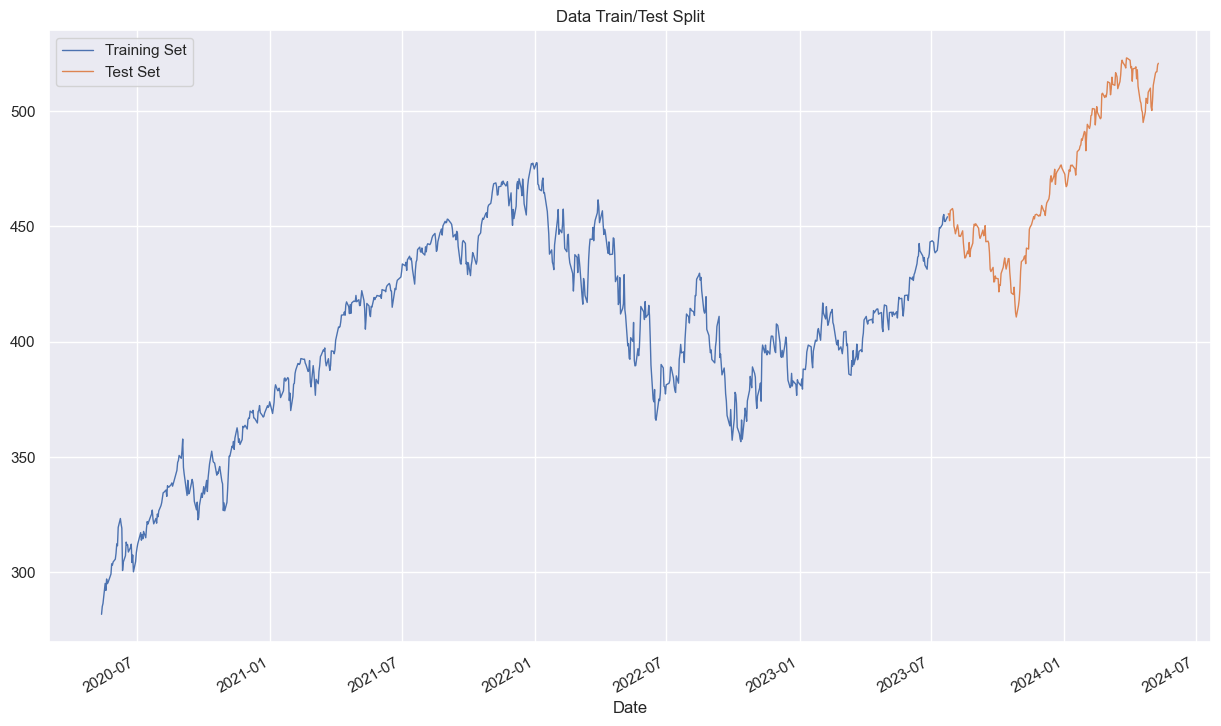

[0]	validation_0-rmse:398.00686	validation_1-rmse:466.99748
[100]	validation_0-rmse:146.76730	validation_1-rmse:191.63300
[200]	validation_0-rmse:54.23986	validation_1-rmse:85.61385
[300]	validation_0-rmse:20.11845	validation_1-rmse:45.65562
[400]	validation_0-rmse:7.60932	validation_1-rmse:30.79175
[500]	validation_0-rmse:3.14815	validation_1-rmse:24.54697
[600]	validation_0-rmse:1.69002	validation_1-rmse:21.97846
[700]	validation_0-rmse:1.24694	validation_1-rmse:20.79748
[800]	validation_0-rmse:1.07577	validation_1-rmse:20.32655
[900]	validation_0-rmse:0.96357	validation_1-rmse:20.11025
[1000]	validation_0-rmse:0.86921	validation_1-rmse:20.02748
[1100]	validation_0-rmse:0.78595	validation_1-rmse:19.97675
[1200]	validation_0-rmse:0.71427	validation_1-rmse:19.93608
[1300]	validation_0-rmse:0.65262	validation_1-rmse:19.92108
[1400]	validation_0-rmse:0.60036	validation_1-rmse:19.90569
[1500]	validation_0-rmse:0.55350	validation_1-rmse:19.89214
[1600]	validation_0-rmse:0.51196	validation_

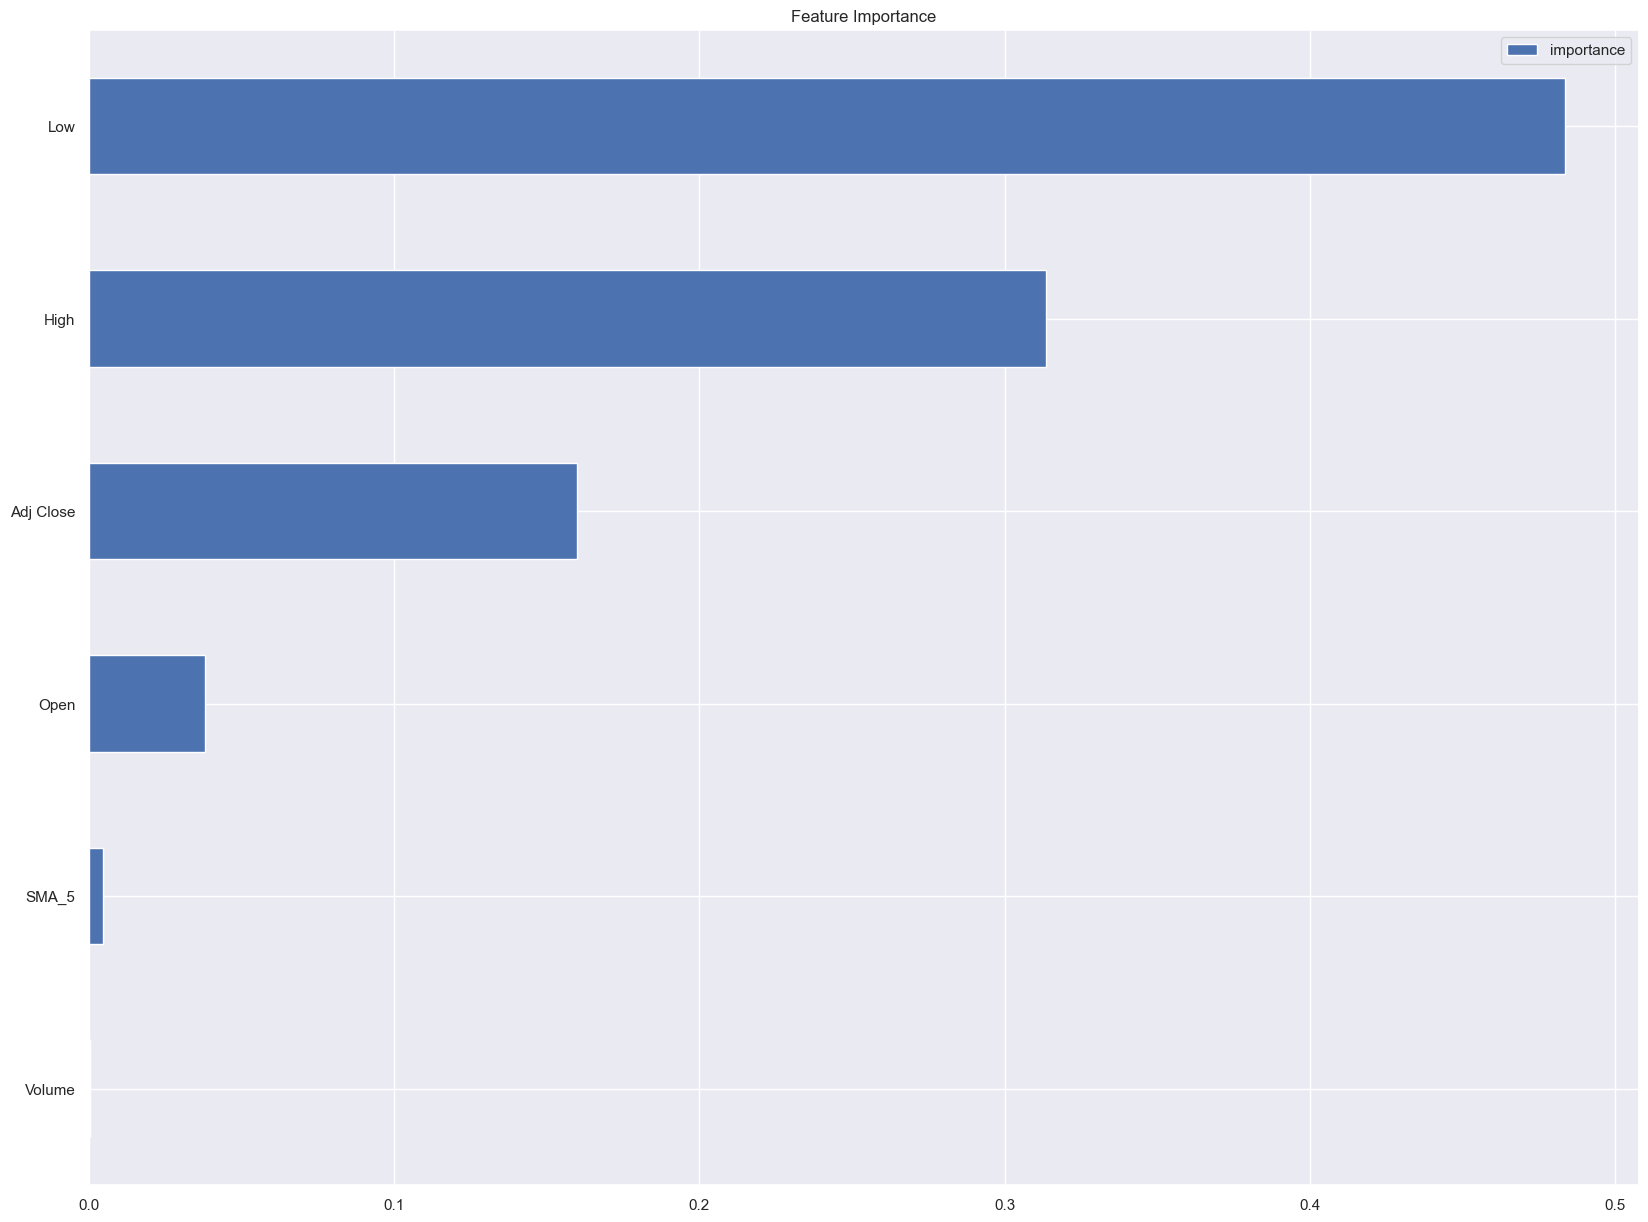

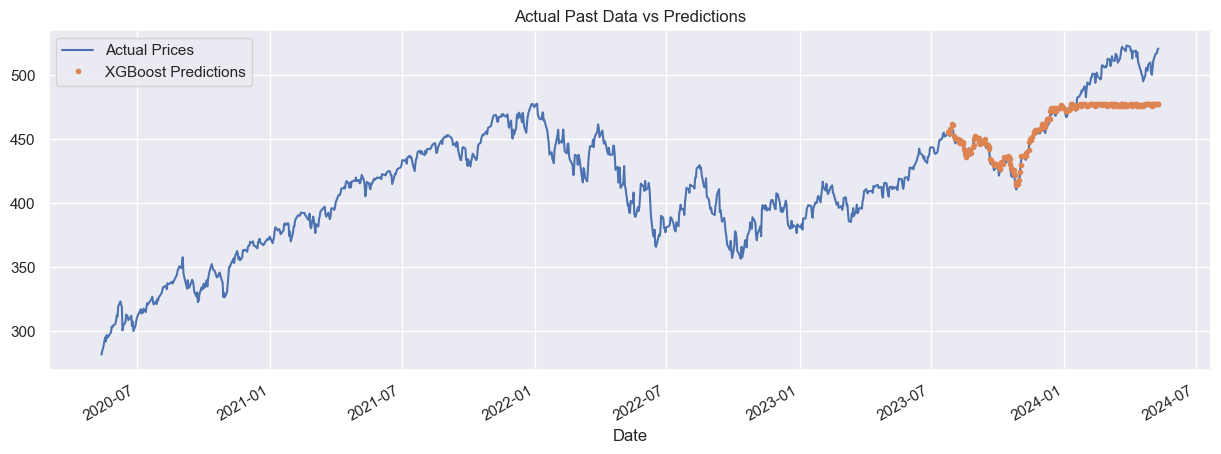

The Mean Squared Error using XGBoost model was :  19.85820565549962


,Metric,Value
0,MAPE,2.56
1,MAE,12.86
2,MSE,394.35
3,RMSE,19.86
4,R2,0.62
5,SMAPE,2.63


In [17]:
#step 1 - import the required dataset
df = stock_data('SPY', 4,'SPY')
df.drop(['comany_name'],axis=1)

#step 2 - do the required feature engineering on the dataset
feature_engineering(df)

#step 3 - once we have created the required features, we can now create test and train sets
train,test = preprocess_data(df)

#step 4 - Fit the XGBoost model and train it on the prepared data
XGB ,x_test= XBGoostRegression(train,test)

#step 5 - evalute the model that we trained on various parameters
y_true,y_pred=evaluate_xgboost(XGB,test,train,df,x_test)

df=evaluate_metrics(y_true,y_pred)
df

[*********************100%%**********************]  1 of 1 completed


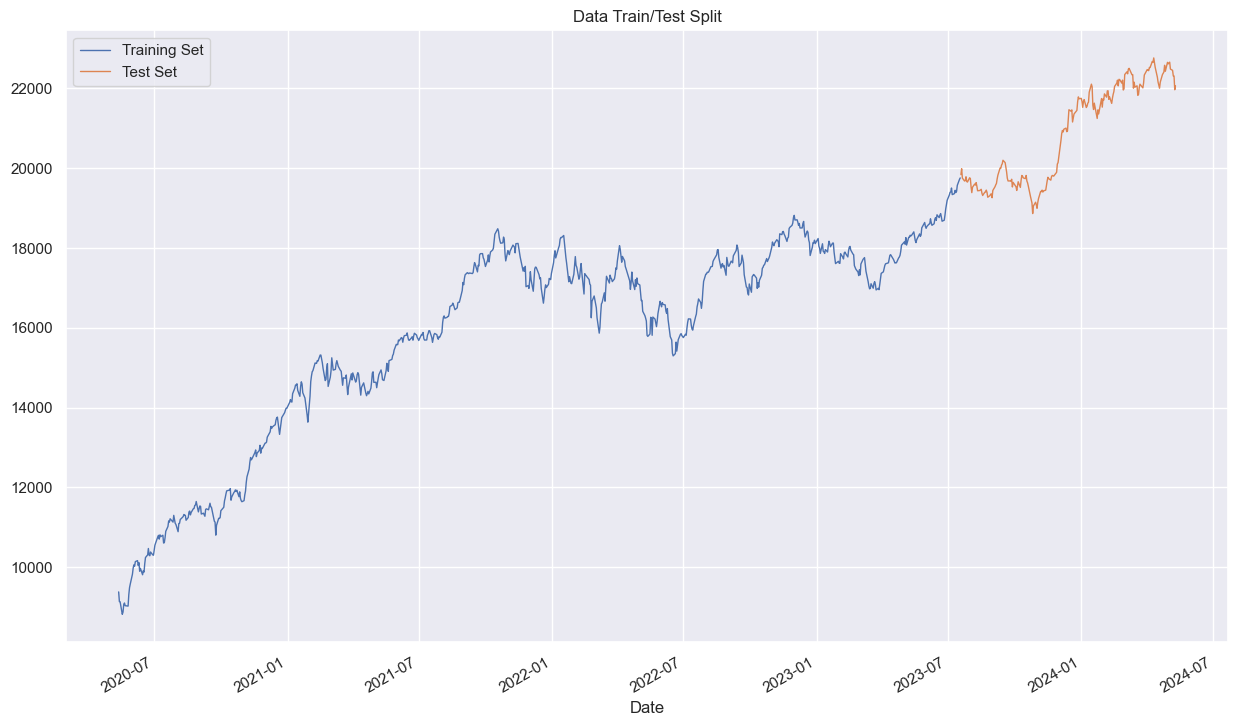

[0]	validation_0-rmse:15867.95794	validation_1-rmse:20695.10860
[100]	validation_0-rmse:5853.91478	validation_1-rmse:9465.52236
[200]	validation_0-rmse:2165.15170	validation_1-rmse:5054.40975
[300]	validation_0-rmse:803.88717	validation_1-rmse:3146.47483
[400]	validation_0-rmse:300.16463	validation_1-rmse:2358.67935
[500]	validation_0-rmse:114.83105	validation_1-rmse:2046.73747
[600]	validation_0-rmse:48.24742	validation_1-rmse:1894.98498
[700]	validation_0-rmse:25.97520	validation_1-rmse:1812.44098
[800]	validation_0-rmse:19.14546	validation_1-rmse:1772.97012
[900]	validation_0-rmse:16.75236	validation_1-rmse:1751.46064
[1000]	validation_0-rmse:15.35022	validation_1-rmse:1740.44587
[1100]	validation_0-rmse:14.32982	validation_1-rmse:1737.76233
[1200]	validation_0-rmse:13.33384	validation_1-rmse:1736.20946
[1300]	validation_0-rmse:12.39828	validation_1-rmse:1735.50278
[1390]	validation_0-rmse:11.67264	validation_1-rmse:1735.10405


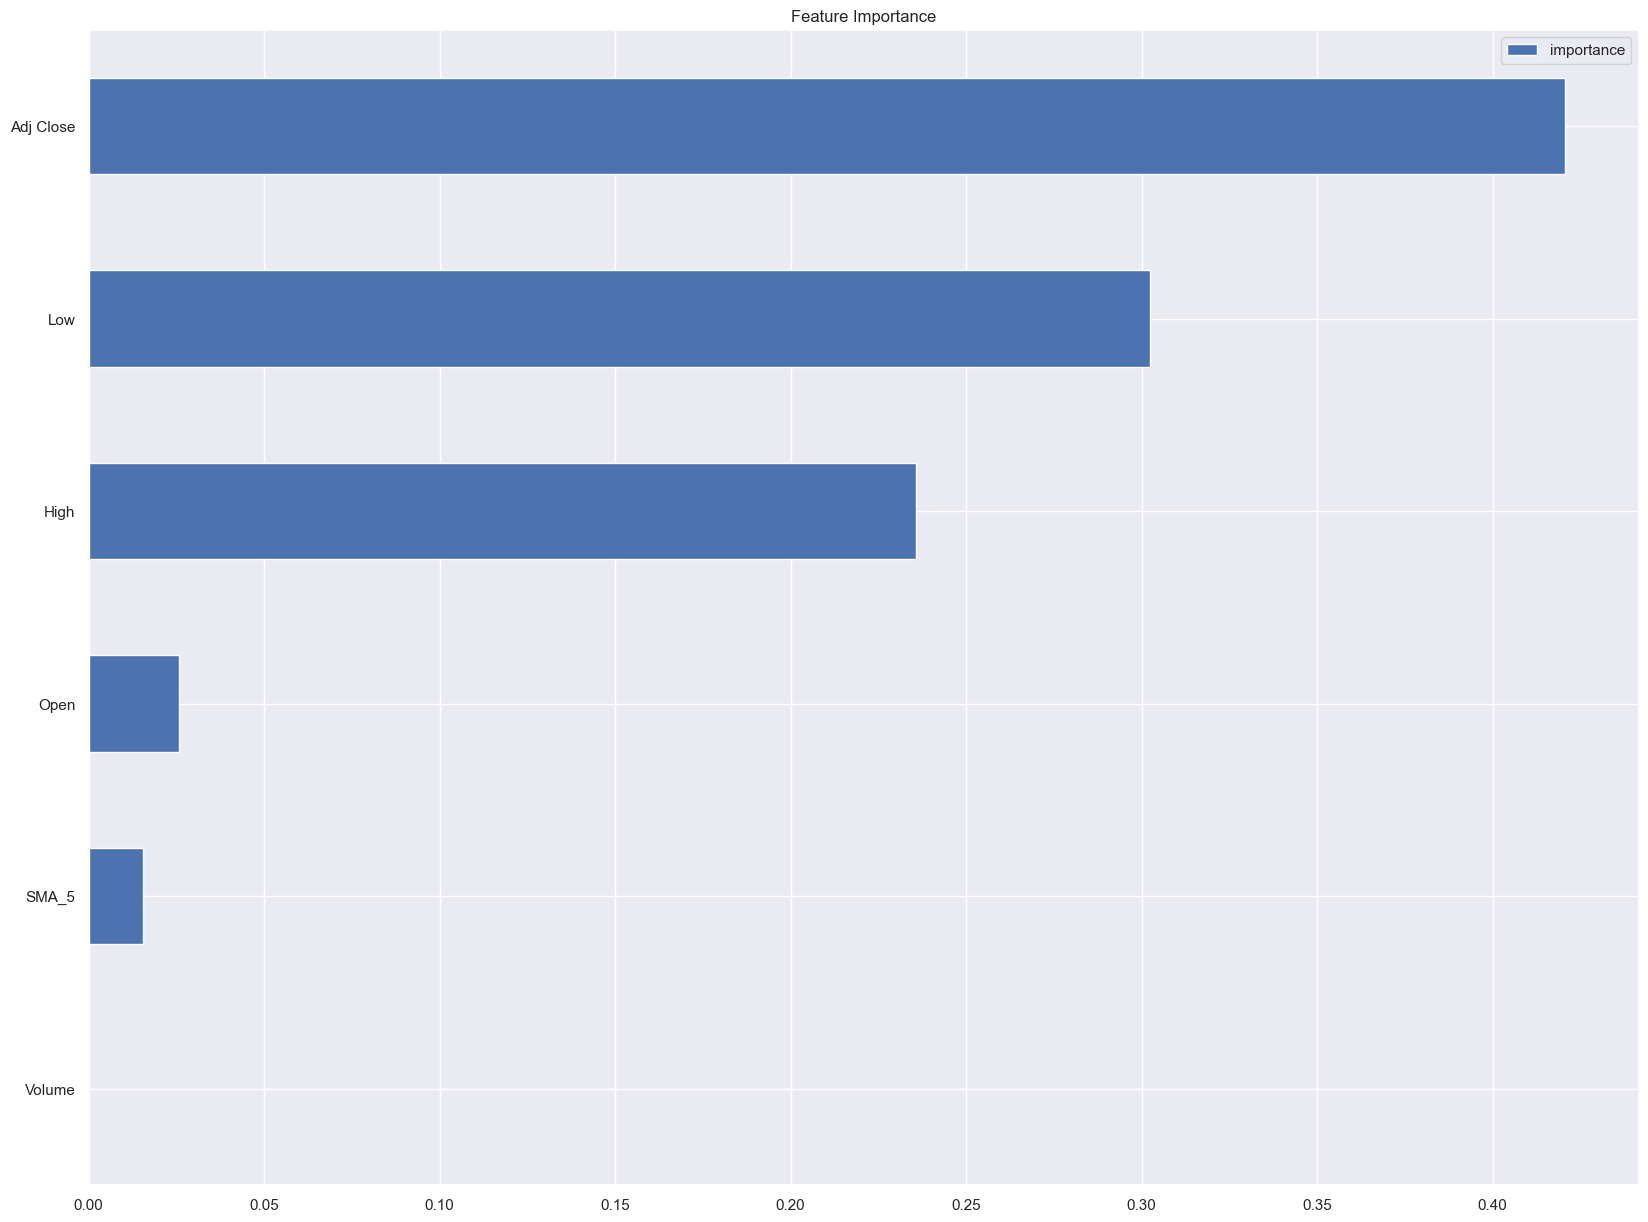

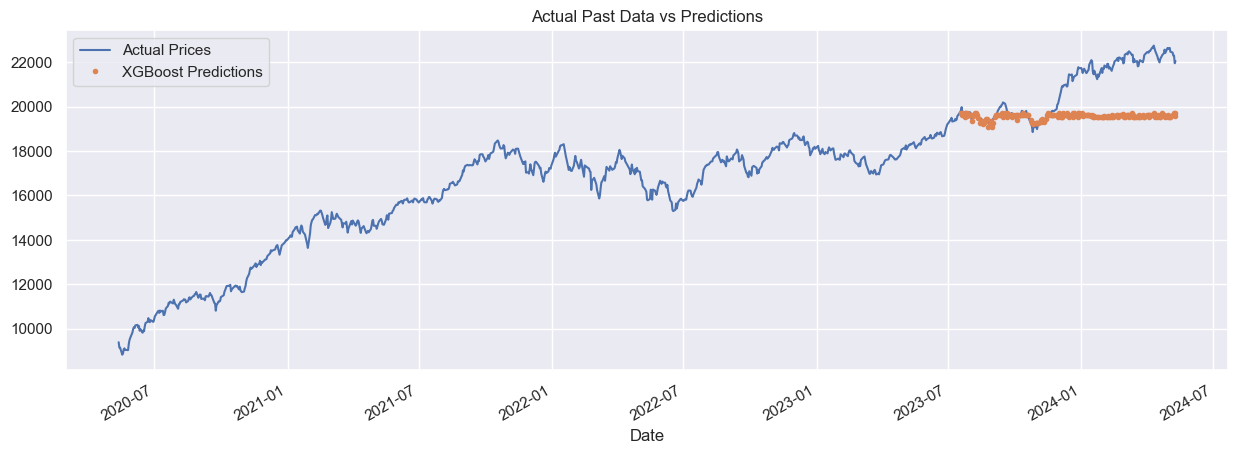

The Mean Squared Error using XGBoost model was :  1734.9069076834917


,Metric,Value
0,MAPE,5.95
1,MAE,1302.35
2,MSE,3009901.98
3,RMSE,1734.91
4,R2,-1.02
5,SMAPE,6.28


In [18]:
#step 1 - import the required dataset
df = stock_data('^NSEI', 4,'Nifty 50')
df.drop(['comany_name'],axis=1)

#step 2 - do the required feature engineering on the dataset
feature_engineering(df)

#step 3 - once we have created the required features, we can now create test and train sets
train,test = preprocess_data(df)

#step 4 - Fit the XGBoost model and train it on the prepared data
XGB ,x_test= XBGoostRegression(train,test)

#step 5 - evalute the model that we trained on various parameters
y_true,y_pred=evaluate_xgboost(XGB,test,train,df,x_test)

df=evaluate_metrics(y_true,y_pred)
df

[*********************100%%**********************]  1 of 1 completed


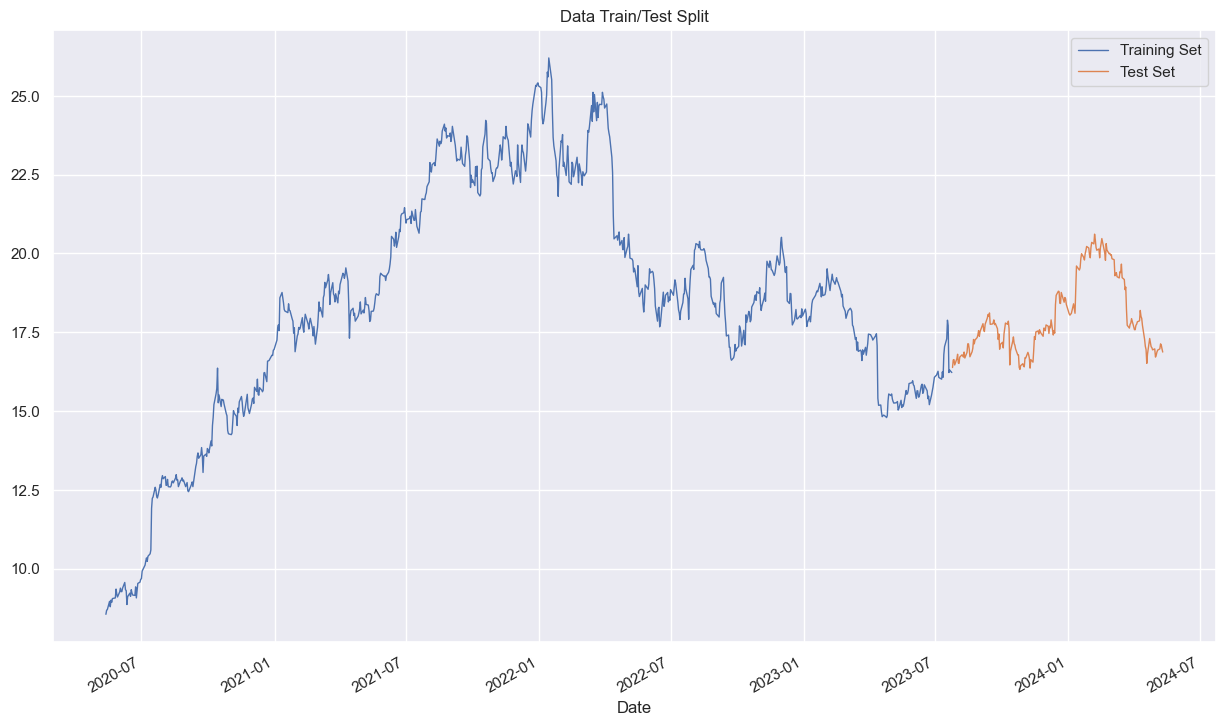

[0]	validation_0-rmse:18.06368	validation_1-rmse:17.31453
[100]	validation_0-rmse:6.68064	validation_1-rmse:6.32862
[200]	validation_0-rmse:2.47875	validation_1-rmse:2.24931
[300]	validation_0-rmse:0.92506	validation_1-rmse:0.76179
[400]	validation_0-rmse:0.35344	validation_1-rmse:0.23123
[500]	validation_0-rmse:0.15065	validation_1-rmse:0.10124
[558]	validation_0-rmse:0.10343	validation_1-rmse:0.11126


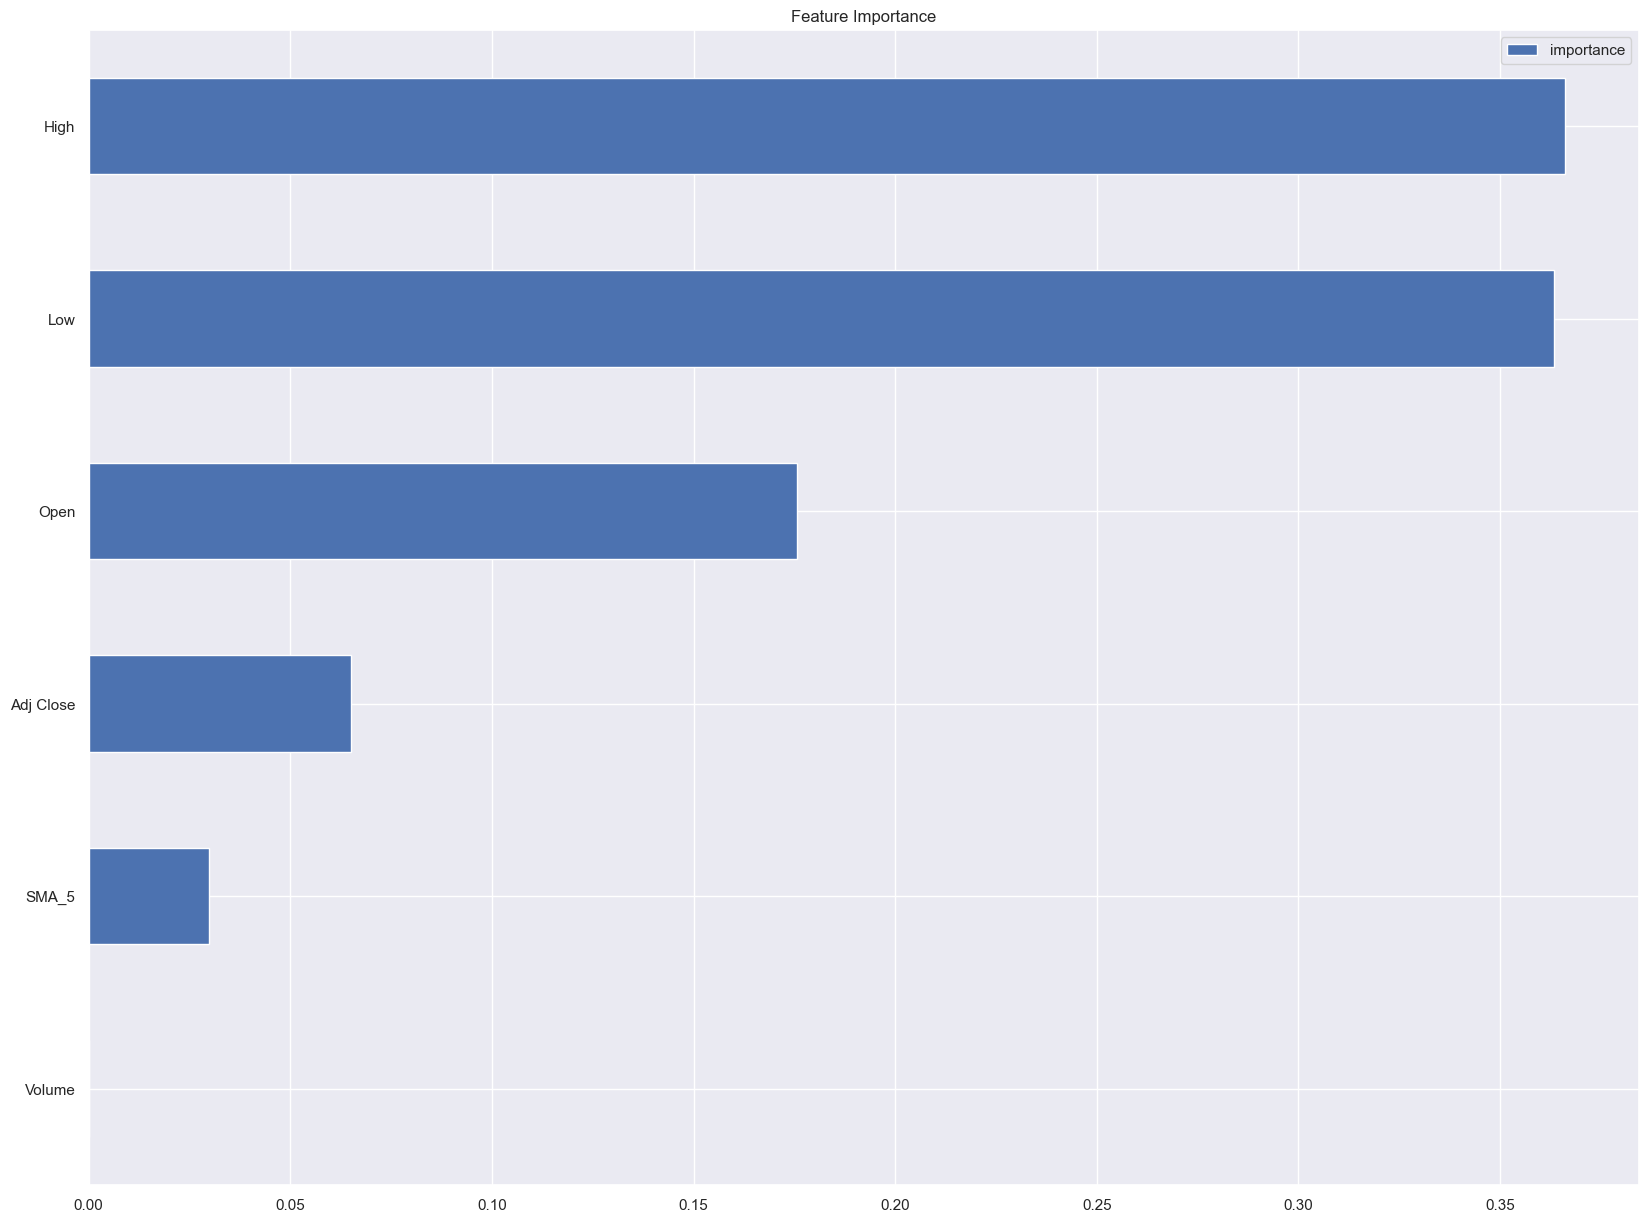

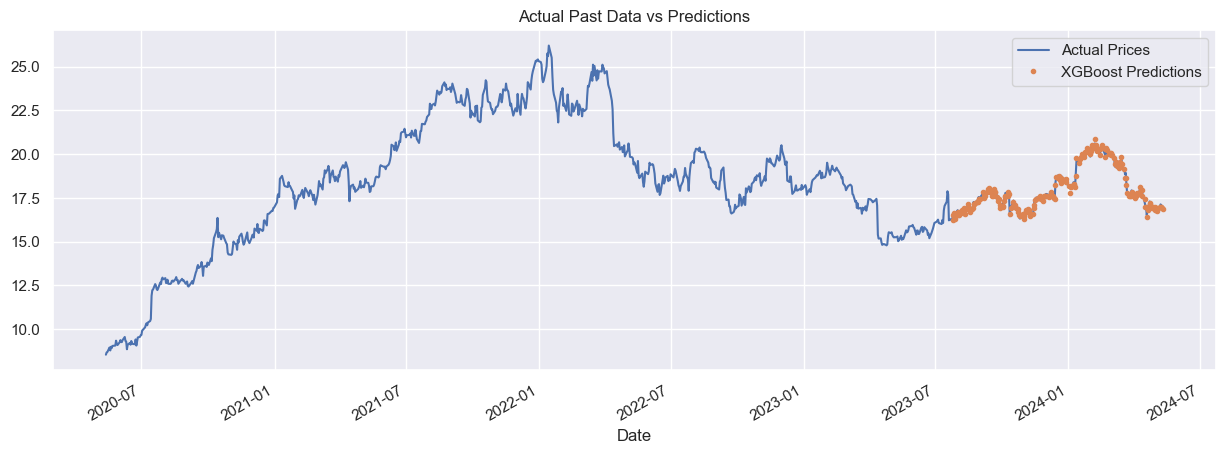

The Mean Squared Error using XGBoost model was :  0.10105506852870891


,Metric,Value
0,MAPE,0.44
1,MAE,0.08
2,MSE,0.01
3,RMSE,0.10
4,R2,0.99
5,SMAPE,0.44


In [19]:
#step 1 - import the required dataset
df = stock_data('INFY', 4,'Infosys')
df.drop(['comany_name'],axis=1)

#step 2 - do the required feature engineering on the dataset
feature_engineering(df)

#step 3 - once we have created the required features, we can now create test and train sets
train,test = preprocess_data(df)

#step 4 - Fit the XGBoost model and train it on the prepared data
XGB ,x_test= XBGoostRegression(train,test)

#step 5 - evalute the model that we trained on various parameters
y_true,y_pred=evaluate_xgboost(XGB,test,train,df,x_test)

df=evaluate_metrics(y_true,y_pred)
df